In [1]:
import numpy as np
import tensorflow as tf
from src.util import plot_voxel

# import vae
from src.vae import vae_model

2024-05-08 06:26:26.002013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Stage 3

_Build the full reconstruction network architecture_

1. Load the VAE $\Psi : \mathbf{z} \mapsto \hat{\gamma}$
2. Load the mapper $\Xi : \mathbf{u} \mapsto \mathbf{z}$
3. Load the material classificator $\Upsilon : \mathbf{u} \mapsto \mathbf{m}$

The final model is described by:

$$\Gamma := \Xi \circ \Psi : \mathbf{u} \mapsto \mathbf{z} \mapsto \hat{\gamma} $$

with the material classification model:

$$\Upsilon : \mathbf{u} \mapsto \mathbf{m} $$

## *i)* Load the VAE

In [2]:
vae = vae_model()
vae.load_weights("models/vaes/vae_4.weights.h5")
vae.summary()

Φ = vae.encoder
Ψ = vae.decoder

2024-05-08 06:26:33.552085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46873 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-05-08 06:26:33.552728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46873 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ VAE_encoder (Functional)        │ ?                      │        11,039 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VAE_decoder (Functional)        │ ?                      │        11,467 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,506 (87.91 KB)

 Trainable params: 22,444 (87.67 KB)

 Non-trainable params: 62 (248.00 B)

In [4]:
tmp = np.load("models/mapper_test.npz", allow_pickle=True)
X_test, z_test, γ_test = tmp["X_test"], tmp["z_test"], tmp["gamma_test"]
print(X_test.shape, z_test.shape, γ_test.shape)

(6210, 64, 64, 1) (6210, 8) (6210, 32, 32, 32, 1)


In [5]:
_, _, z_pred = Φ.predict(γ_test)
γ_pred = Ψ.predict(z_pred)

I0000 00:00:1715149609.986206  150187 service.cc:145] XLA service 0x7fce14044df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715149609.986272  150187 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1715149609.986279  150187 service.cc:153]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-08 06:26:50.032880: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-08 06:26:50.121299: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 35/195 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

I0000 00:00:1715149610.622120  150187 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


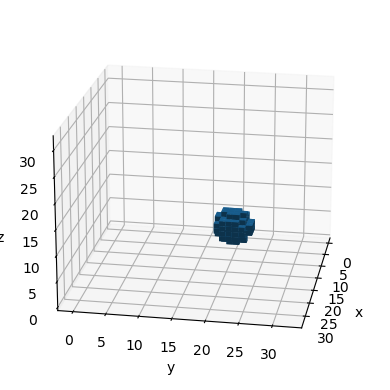

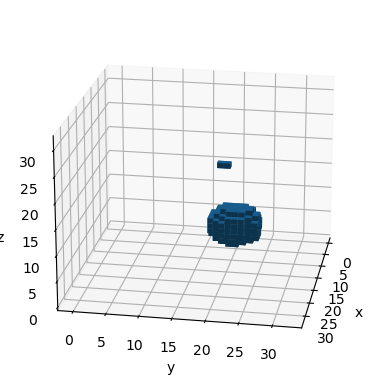

----------


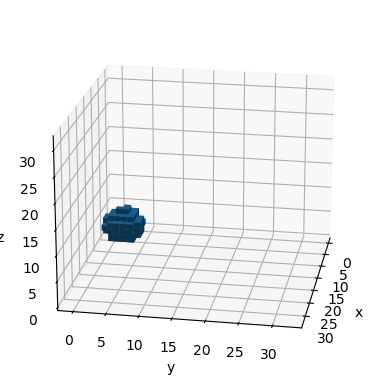

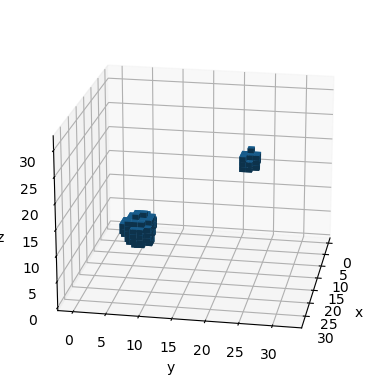

----------


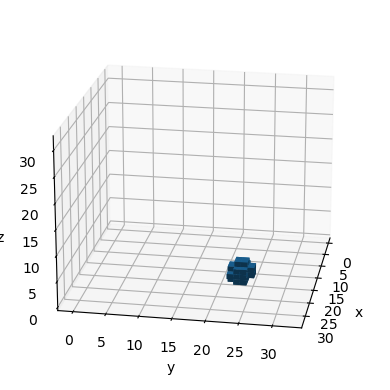

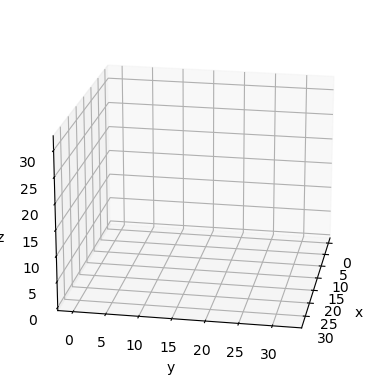

----------


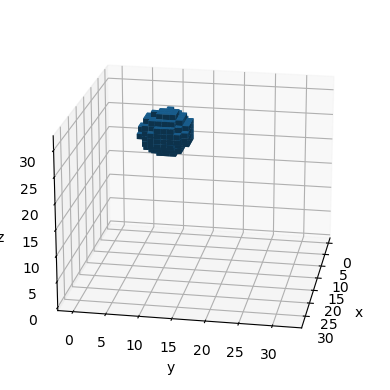

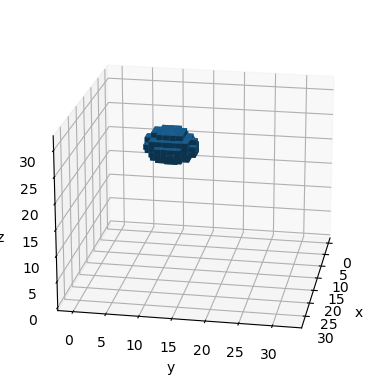

----------


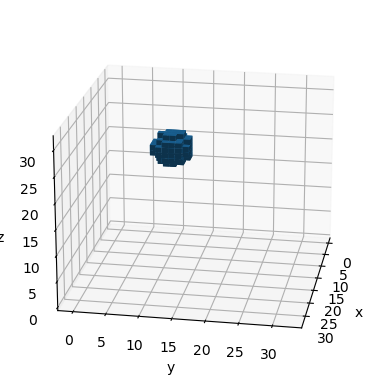

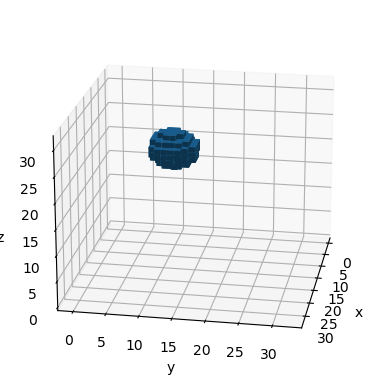

----------


In [13]:
for rdn in np.random.randint(low=0, high=X_test.shape[0], size=5):
    plot_voxel(γ_test[rdn, :, :, :, 0])
    sgl_pred = γ_pred[rdn, :, :, :, 0]
    sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)
    sgl_pred = np.round(sgl_pred, 1) + 0.35  #  round offset
    sgl_pred = np.round(sgl_pred)
    plot_voxel(sgl_pred)
    print("----------")

## *ii)* Load the Mapper $\Xi$ and the material classification network $\Upsilon$

In [15]:
def Upsilon_model(input_shape=(64, 64, 1), latent_dim=1, kernel=3):
    mapper_input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Flatten()(x)
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
    return tf.keras.Model(mapper_input, mapper_output)


Υ = Upsilon_model()
Υ.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 16, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 4, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 1, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 1, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217 (16.47 KB)

 Trainable params: 4,217 (16.47 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
Υ.load_weights("models/mapper_4/model.keras")

In [17]:
def Xi_model(input_shape=(64, 64, 1), latent_dim=8, kernel=3):
    mapper_input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Flatten()(x)
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
    return tf.keras.Model(mapper_input, mapper_output)


Ξ = Xi_model()
# Ξ.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
Ξ.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 16, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 4, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 1, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 1, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,672 (18.25 KB)

 Trainable params: 4,672 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
Ξ.load_weights("models/material_mapper.weights.h5")

## *iii)* Setup the final reconstruction network

In [21]:
γ_hat = Ψ.predict(Ξ.predict(X_test))

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


In [23]:
m = np.round(Υ.predict(X_test))

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


In [29]:
np.quantile(m, 0.75)

1.0